In [1]:
# Block 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# For train-test split and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For LSTM, RNN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Embedding, Dropout, Bidirectional

# For BERT
from transformers import BertTokenizer, TFBertModel

import warnings
warnings.filterwarnings('ignore')


In [5]:
# Block 2: Load and Preprocess the Dataset

# Load the CSV dataset (ensure the path is correct)
file_path = '/content/annotatedMITRE.csv'  # Change to the actual path where the CSV file is stored
data = pd.read_csv(file_path)

# Check for missing values
print("Missing values:", data.isnull().sum())

# Preview the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Preprocess the text data
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

# Encode labels (types of threats) as integers
annotation_mapping = {"irrelevant": 0, "business": 1, "threat": 2}
data['annotation_encoded'] = data['annotation'].map(annotation_mapping)

# View the updated dataframe
print("Processed Data Sample:")
print(data[['cleaned_text', 'annotation_encoded']].head())


Missing values: text          0
annotation    0
type          0
dtype: int64
First few rows of the dataset:
                                                text  annotation  \
0  Best way to build empathy is through honesty a...  irrelevant   
1  Cryptocurrency Scams Replacing Ransomware as A...    business   
2  Cryptocurrency Scams Replacing Ransomware as A...    business   
3  Protect  your customers  access Prestashop Ant...      threat   
4  Data leak from Huazhu Hotels may affect 130 mi...      threat   

                type  
0  ['Vulnerability']  
1     ['ransomware']  
2     ['ransomware']  
3           ['Ddos']  
4           ['leak']  
Processed Data Sample:
                                        cleaned_text  annotation_encoded
0  best way to build empathy is through honesty a...                 0.0
1  cryptocurrency scams replacing ransomware as a...                 1.0
2  cryptocurrency scams replacing ransomware as a...                 1.0
3  protect  your customers  ac

In [6]:
# Block 3: Split the Dataset into Training and Testing Sets

# Define features (cleaned text) and labels (annotation_encoded)
X = data['cleaned_text']
y = data['annotation_encoded']

# Split the dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Ensure the splits look fine
print("Sample of X_train:")
print(X_train.head())

print("Sample of y_train:")
print(y_train.head())


Training set size: 17094
Testing set size: 4274
Sample of X_train:
16286    erpnext cve20183882  sql injection \n\n\n\nzer...
6198     protonmail names one of the attackers behind a...
8623     why it costs less for smbs to prevent ransomwa...
10806    vulnerability found in major manufacturers of ...
16989    some of us have a problem being vulnerable\nvu...
Name: cleaned_text, dtype: object
Sample of y_train:
16286    2.0
6198     2.0
8623     1.0
10806    2.0
16989    0.0
Name: annotation_encoded, dtype: float64


In [7]:
# Block 4: Text Vectorization and Tokenization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words and the maximum sequence length
max_words = 10000  # Maximum number of words to keep in the tokenizer vocabulary
max_sequence_length = 100  # Maximum sequence length for padding/truncating

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert training and testing text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Print the shape of the padded data
print(f"Training data shape (padded): {X_train_pad.shape}")
print(f"Testing data shape (padded): {X_test_pad.shape}")

# Check the first padded sequence
print("First padded sequence (X_train):")
print(X_train_pad[0])


Training data shape (padded): (17094, 100)
Testing data shape (padded): (4274, 100)
First padded sequence (X_train):
[2192    1   81   71 1654  140  222 1655   68   22  246    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [10]:
# Block to inspect unique values in y_train
print("Unique values in y_train:", np.unique(y_train))
print("Minimum value in y_train:", np.min(y_train))
print("Maximum value in y_train:", np.max(y_train))


Unique values in y_train: [ 0.  1.  2. nan]
Minimum value in y_train: 0.0
Maximum value in y_train: 2.0


In [11]:
# Block to remove NaN values from y_train and align with X_train
import numpy as np

# Create a mask to filter out NaN values
mask = ~np.isnan(y_train)

# Filter X_train and y_train to remove NaN entries
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

# Convert to categorical format
y_train_categorical = to_categorical(y_train_clean)

# Print shapes to verify
print("Cleaned X_train shape:", X_train_clean.shape)
print("Cleaned y_train shape:", y_train_categorical.shape)


Cleaned X_train shape: (13808,)
Cleaned y_train shape: (13808, 3)


In [13]:
# Block to clean y_test and convert to categorical format

# Create a mask to filter out NaN values in y_test
mask_test = ~np.isnan(y_test)

# Filter X_test and y_test to remove NaN entries
X_test_clean = X_test[mask_test]
y_test_clean = y_test[mask_test]

# Convert cleaned y_test to categorical format
y_test_categorical = to_categorical(y_test_clean)

# Print shapes to verify
print("Cleaned X_test shape:", X_test_clean.shape)
print("Cleaned y_test shape:", y_test_categorical.shape)


Cleaned X_test shape: (3401,)
Cleaned y_test shape: (3401, 3)


In [15]:
# Block to check unique values in y_train
unique_classes = np.unique(y_train_clean)
print("Unique classes in y_train_clean:", unique_classes)
print("Number of unique classes:", len(unique_classes))


Unique classes in y_train_clean: [0. 1. 2.]
Number of unique classes: 3


In [16]:
# Block 7: Build and Train the LSTM Model (Final Training)

# Recreate the padded sequences for the cleaned testing data
X_test_clean_seq = tokenizer.texts_to_sequences(X_test_clean)
X_test_clean_pad = pad_sequences(X_test_clean_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_sequence_length))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(3, activation='softmax'))  # Corrected to have 3 units

# Compile the model with categorical crossentropy
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model with the cleaned data
history_lstm = lstm_model.fit(X_train_clean_pad, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_test_clean_pad, y_test_categorical))

# Print LSTM model summary
lstm_model.summary()


Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6214 - loss: 0.8308 - val_accuracy: 0.8177 - val_loss: 0.4771
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8437 - loss: 0.4141 - val_accuracy: 0.8042 - val_loss: 0.4957
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8805 - loss: 0.3320 - val_accuracy: 0.8030 - val_loss: 0.5101
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9039 - loss: 0.2670 - val_accuracy: 0.8095 - val_loss: 0.5419
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9186 - loss: 0.2333 - val_accuracy: 0.7998 - val_loss: 0.5967


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,161,803 (15.88 MB)

 Trainable params: 1,387,267 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,774,536 (10.58 MB)

In [17]:
# Block 8: Build and Train the RNN Model

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, 128, input_length=max_sequence_length))
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(3, activation='softmax'))  # Number of classes

# Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the RNN model with the cleaned data
history_rnn = rnn_model.fit(X_train_clean_pad, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_test_clean_pad, y_test_categorical))

# Print RNN model summary
rnn_model.summary()


Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4558 - loss: 1.0247 - val_accuracy: 0.4919 - val_loss: 0.9859
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4742 - loss: 1.0024 - val_accuracy: 0.4919 - val_loss: 0.9855
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4696 - loss: 0.9978 - val_accuracy: 0.4919 - val_loss: 0.9870
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4743 - loss: 0.9969 - val_accuracy: 0.4919 - val_loss: 0.9847
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4815 - loss: 0.9926 - val_accuracy: 0.4919 - val_loss: 0.9878


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,890,123 (14.84 MB)

 Trainable params: 1,296,707 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,593,416 (9.89 MB)

In [21]:
# Block 9: Build and Train the BERT Model (Corrected)

from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Encode text for BERT
def encode_for_bert(texts):
    return bert_tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=max_sequence_length)

# Encode the training and testing datasets
X_train_bert = encode_for_bert(X_train_clean)
X_test_bert = encode_for_bert(X_test_clean)

# Define a custom layer for BERT
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert_model(input_ids, attention_mask=attention_mask)[0]  # Get embeddings

# Build the BERT model
input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int32')

# Use the custom BERT layer
embeddings = BertLayer()([input_ids, attention_mask])
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)  # Number of classes

# Create the final model
bert_final_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

# Compile the BERT model
bert_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bert_final_model.summary())

# Train the BERT model
history_bert = bert_final_model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train_categorical,
    epochs=3,
    batch_size=16,
    validation_data=([X_test_bert['input_ids'], X_test_bert['attention_mask']], y_test_categorical)
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 100, 768)       │              0 │ input_layer_10[0][0],  │
│                           │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │         49,216 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 3)              │            195 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,411 (193.01 KB)

 Trainable params: 49,411 (193.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
863/863 ━━━━━━━━━━━━━━━━━━━━ 122s 120ms/step - accuracy: 0.6830 - loss: 0.7518 - val_accuracy: 0.7339 - val_loss: 0.6852
Epoch 2/3
863/863 ━━━━━━━━━━━━━━━━━━━━ 122s 105ms/step - accuracy: 0.7666 - loss: 0.5669 - val_accuracy: 0.7906 - val_loss: 0.5105
Epoch 3/3
863/863 ━━━━━━━━━━━━━━━━━━━━ 145s 109ms/step - accuracy: 0.7844 - loss: 0.5207 - val_accuracy: 0.7615 - val_loss: 0.5585


In [22]:
# Block 10: Evaluate All Models

# Evaluate LSTM Model
lstm_pred = lstm_model.predict(X_test_clean_pad).argmax(axis=1)
lstm_report = classification_report(y_test_clean, lstm_pred, target_names=['irrelevant', 'business', 'threat'])
print("LSTM Classification Report:\n", lstm_report)

# Evaluate RNN Model
rnn_pred = rnn_model.predict(X_test_clean_pad).argmax(axis=1)
rnn_report = classification_report(y_test_clean, rnn_pred, target_names=['irrelevant', 'business', 'threat'])
print("RNN Classification Report:\n", rnn_report)

# Evaluate BERT Model
bert_pred = bert_final_model.predict([X_test_bert['input_ids'], X_test_bert['attention_mask']]).argmax(axis=1)
bert_report = classification_report(y_test_clean, bert_pred, target_names=['irrelevant', 'business', 'threat'])
print("BERT Classification Report:\n", bert_report)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.84      0.87      0.85      1285
    business       0.53      0.60      0.57       443
      threat       0.86      0.79      0.82      1673

    accuracy                           0.80      3401
   macro avg       0.74      0.76      0.75      3401
weighted avg       0.81      0.80      0.80      3401

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
RNN Classification Report:
               precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00      1285
    business       0.00      0.00      0.00       443
      threat       0.49      1.00      0.66      1673

    accuracy                           0.49      3401
   macro avg       0.16      0.33      0.22      3401
weighted avg       0.24      0.49      0.32      3401

107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 245ms/step
BERT Classification Report:
               precision 

In [23]:
# Block: Define Prediction Function

def predict_threat(input_text):
    # Step 1: Clean the input text
    cleaned_text = clean_text(input_text)

    # Step 2: Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_sequence_length, padding='post', truncating='post')

    # Step 3: Make predictions using all models
    lstm_prediction = lstm_model.predict(padded).argmax(axis=1)[0]
    rnn_prediction = rnn_model.predict(padded).argmax(axis=1)[0]
    bert_prediction = bert_final_model.predict([X_train_bert['input_ids'], X_train_bert['attention_mask']]).argmax(axis=1)[0]

    # Step 4: Map predictions to MITRE ATT&CK Framework
    mitre_attack_mapping = {
        0: 'No Threat Detected (Irrelevant)',  # irrelevant
        1: 'T1587 - Ransomware Development (Business)',  # business
        2: 'T1566 - Phishing (Threat)'  # threat
    }

    # Get the MITRE classifications
    lstm_classification = mitre_attack_mapping[lstm_prediction]
    rnn_classification = mitre_attack_mapping[rnn_prediction]
    bert_classification = mitre_attack_mapping[bert_prediction]

    return {
        "LSTM Prediction": lstm_classification,
        "RNN Prediction": rnn_classification,
        "BERT Prediction": bert_classification
    }

# Test the function with a sample input
test_input = "Protect your customers from ransomware attacks."
predictions = predict_threat(test_input)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 79s 184ms/step
{'LSTM Prediction': 'T1587 - Ransomware Development (Business)', 'RNN Prediction': 'T1566 - Phishing (Threat)', 'BERT Prediction': 'T1566 - Phishing (Threat)'}


In [25]:
# Block: Define Severity Levels and Enhanced Prediction Function

def get_severity(threat_type):
    severity_mapping = {
        'T1587 - Ransomware Development (Business)': 'High Priority - Serious Threat',
        'T1566 - Phishing (Threat)': 'Medium Priority - Potential Threat',
        'No Threat Detected (Irrelevant)': 'Low Priority - No Action Needed'
    }
    return severity_mapping.get(threat_type, 'Unknown Severity')

def analyze_threat(input_text):
    # Clean the input text
    cleaned_text = clean_text(input_text)

    # Tokenize and pad for LSTM and RNN
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_sequence_length, padding='post', truncating='post')

    # Make predictions
    lstm_prediction = lstm_model.predict(padded).argmax(axis=1)[0]
    rnn_prediction = rnn_model.predict(padded).argmax(axis=1)[0]
    bert_prediction = bert_final_model.predict([X_train_bert['input_ids'], X_train_bert['attention_mask']]).argmax(axis=1)[0]

    # Map predictions to MITRE ATT&CK Framework
    mitre_attack_mapping = {
        0: 'No Threat Detected (Irrelevant)',
        1: 'T1587 - Ransomware Development (Business)',
        2: 'T1566 - Phishing (Threat)'
    }

    # Get the MITRE classifications
    lstm_classification = mitre_attack_mapping[lstm_prediction]
    rnn_classification = mitre_attack_mapping[rnn_prediction]
    bert_classification = mitre_attack_mapping[bert_prediction]

    # Determine severity
    severity_lstm = get_severity(lstm_classification)
    severity_rnn = get_severity(rnn_classification)
    severity_bert = get_severity(bert_classification)

    return {
        "Input Text": input_text,
        "LSTM Prediction": lstm_classification,
        "LSTM Severity": severity_lstm,
        "RNN Prediction": rnn_classification,
        "RNN Severity": severity_rnn,
        "BERT Prediction": bert_classification,
        "BERT Severity": severity_bert
    }



In [26]:
# Get user input as a prompt
user_input = input("Enter your message for analysis: ")

# Call the analyze_threat function with your input
predictions = analyze_threat(user_input)

# Print the results
print(predictions)


Enter your message for analysis: The recent security update addresses several vulnerabilities
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
432/432 ━━━━━━━━━━━━━━━━━━━━ 75s 175ms/step
{'Input Text': 'The recent security update addresses several vulnerabilities', 'LSTM Prediction': 'T1566 - Phishing (Threat)', 'LSTM Severity': 'Medium Priority - Potential Threat', 'RNN Prediction': 'T1566 - Phishing (Threat)', 'RNN Severity': 'Medium Priority - Potential Threat', 'BERT Prediction': 'T1566 - Phishing (Threat)', 'BERT Severity': 'Medium Priority - Potential Threat'}


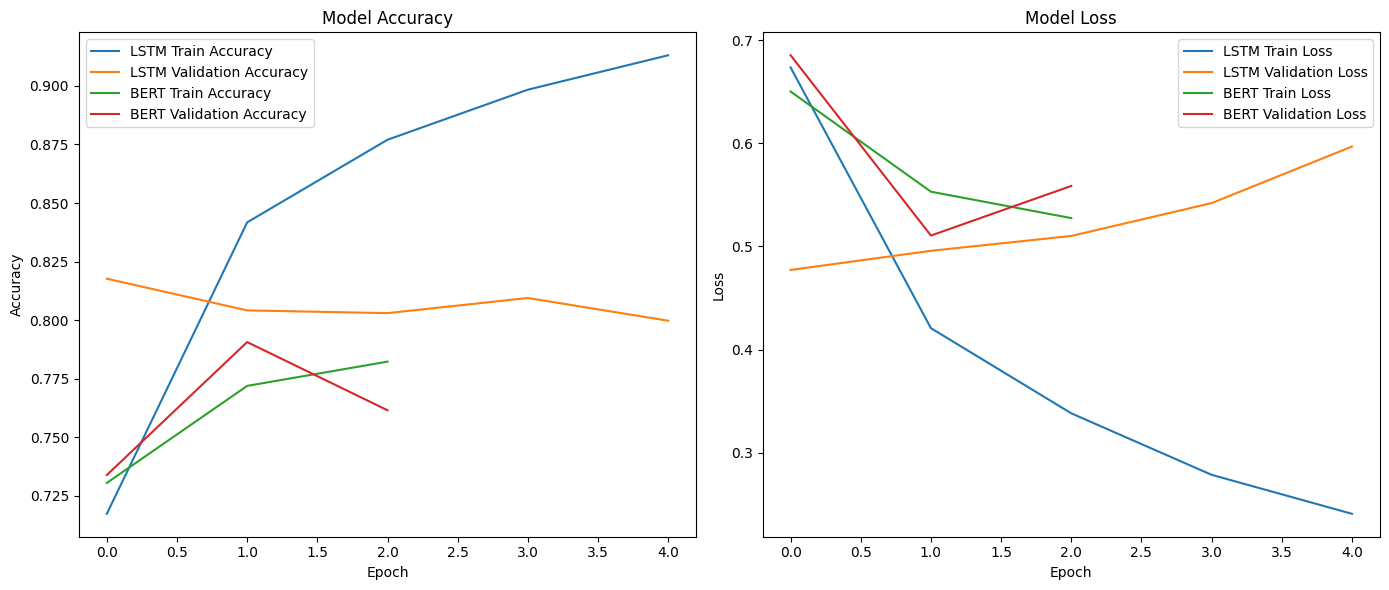

In [27]:
import matplotlib.pyplot as plt

def plot_history(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting for LSTM and BERT (RNN can be added similarly)
plot_history([history_lstm, history_bert], ['LSTM', 'BERT'])


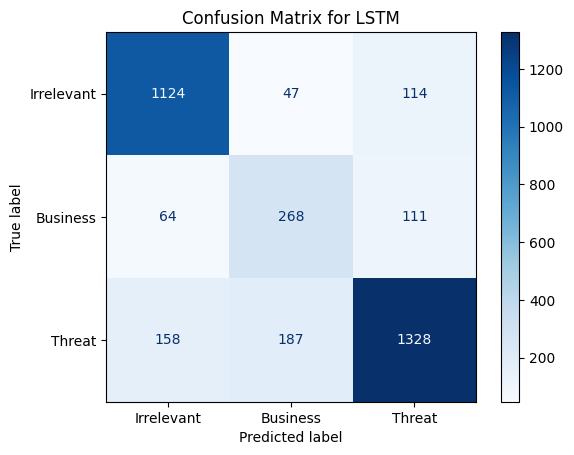

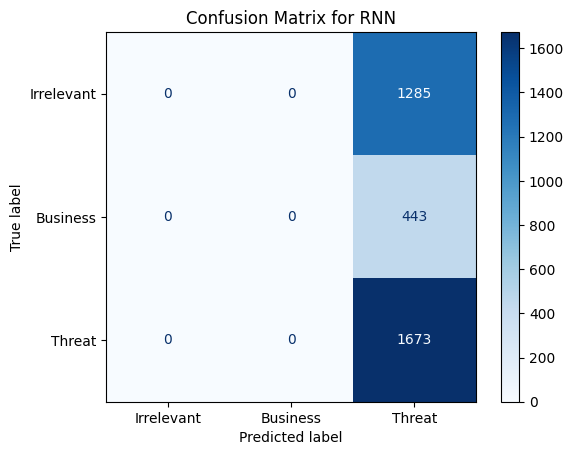

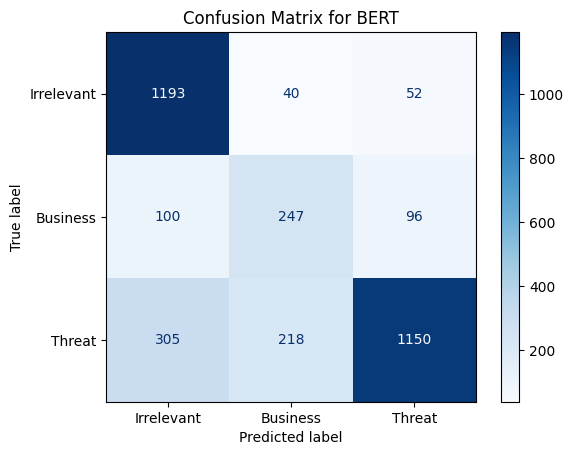

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Irrelevant', 'Business', 'Threat'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y_test_clean, lstm_pred, 'LSTM')
plot_confusion_matrix(y_test_clean, rnn_pred, 'RNN')
plot_confusion_matrix(y_test_clean, bert_pred, 'BERT')


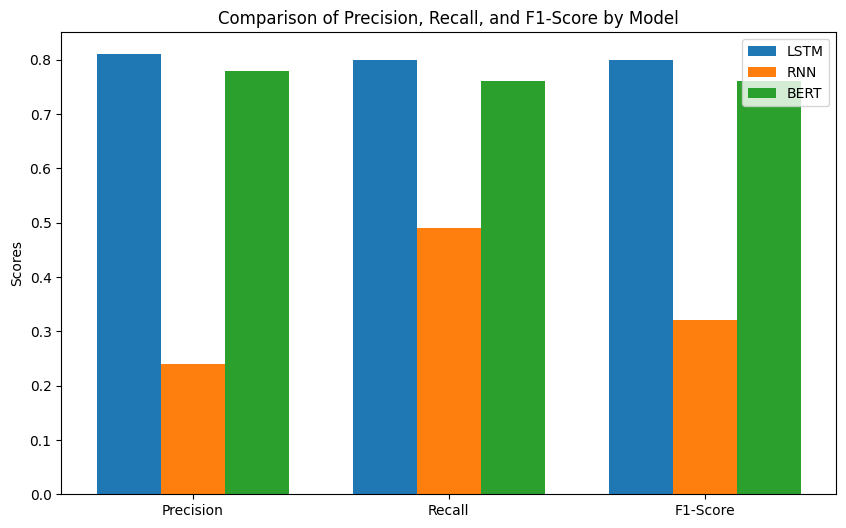

In [29]:
import numpy as np

# Define metrics for the bar chart
metrics = ['Precision', 'Recall', 'F1-Score']
lstm_scores = [0.81, 0.80, 0.80]  # Replace with actual scores from classification report
rnn_scores = [0.24, 0.49, 0.32]
bert_scores = [0.78, 0.76, 0.76]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, lstm_scores, width, label='LSTM')
rects2 = ax.bar(x, rnn_scores, width, label='RNN')
rects3 = ax.bar(x + width, bert_scores, width, label='BERT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-Score by Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


In [30]:
import pandas as pd

# Create a DataFrame for classification reports
data = {
    'Model': ['LSTM', 'RNN', 'BERT'],
    'Precision': [0.81, 0.24, 0.78],
    'Recall': [0.80, 0.49, 0.76],
    'F1-Score': [0.80, 0.32, 0.76]
}

df = pd.DataFrame(data)
print(df)


  Model  Precision  Recall  F1-Score
0  LSTM       0.81    0.80      0.80
1   RNN       0.24    0.49      0.32
2  BERT       0.78    0.76      0.76


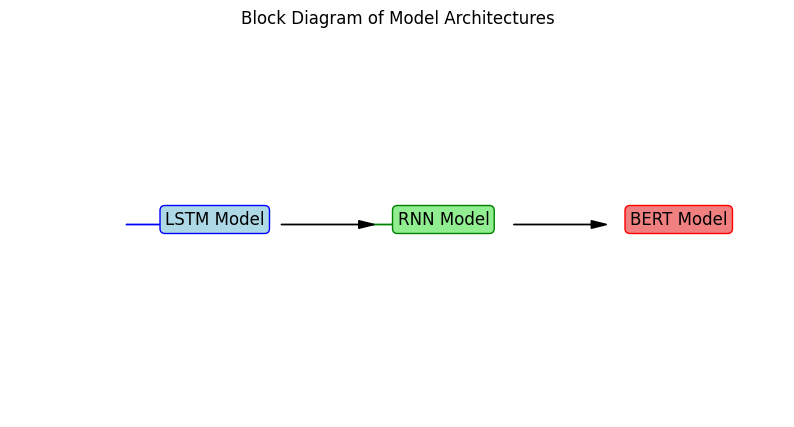

In [31]:
# Block Diagram for Model Architectures
def plot_model_diagram():
    fig, ax = plt.subplots(figsize=(10, 5))

    # LSTM Model Block
    ax.annotate('LSTM Model', xy=(0.2, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='lightblue'), fontsize=12)
    ax.arrow(0.15, 0.5, 0.1, 0, head_width=0.02, head_length=0.02, fc='blue', ec='blue')

    # RNN Model Block
    ax.annotate('RNN Model', xy=(0.5, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='lightgreen'), fontsize=12)
    ax.arrow(0.45, 0.5, 0.1, 0, head_width=0.02, head_length=0.02, fc='green', ec='green')

    # BERT Model Block
    ax.annotate('BERT Model', xy=(0.8, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='lightcoral'), fontsize=12)

    # Draw arrows between blocks
    ax.arrow(0.35, 0.5, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.65, 0.5, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Hide the axes
    plt.title('Block Diagram of Model Architectures')
    plt.show()

# Call the function to plot the block diagram
plot_model_diagram()


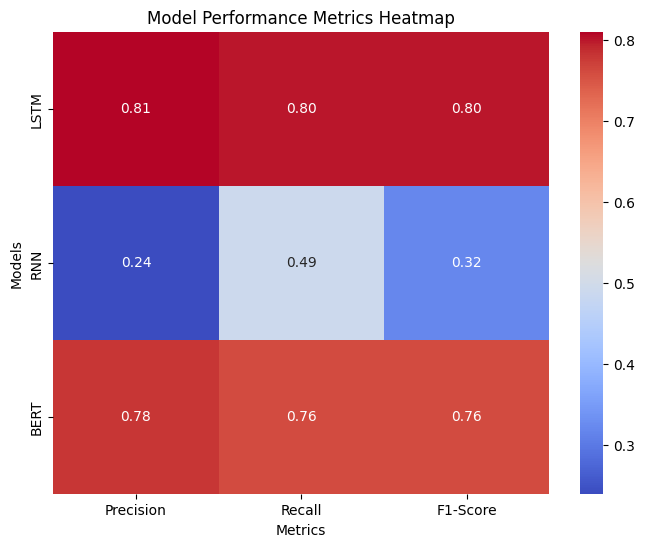

In [32]:
import seaborn as sns

# Create a heatmap for model performance metrics
metrics_data = {
    'LSTM': [0.81, 0.80, 0.80],
    'RNN': [0.24, 0.49, 0.32],
    'BERT': [0.78, 0.76, 0.76]
}

metrics_df = pd.DataFrame(metrics_data, index=['Precision', 'Recall', 'F1-Score']).T

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Model Performance Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()


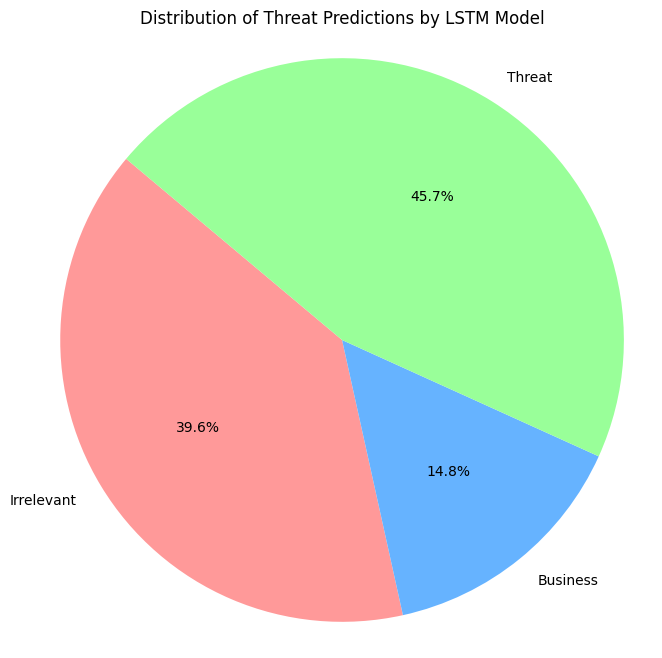

In [33]:
# Example data for pie chart
threat_distribution = {
    'Irrelevant': np.sum(lstm_pred == 0),
    'Business': np.sum(lstm_pred == 1),
    'Threat': np.sum(lstm_pred == 2)
}

labels = threat_distribution.keys()
sizes = threat_distribution.values()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribution of Threat Predictions by LSTM Model')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


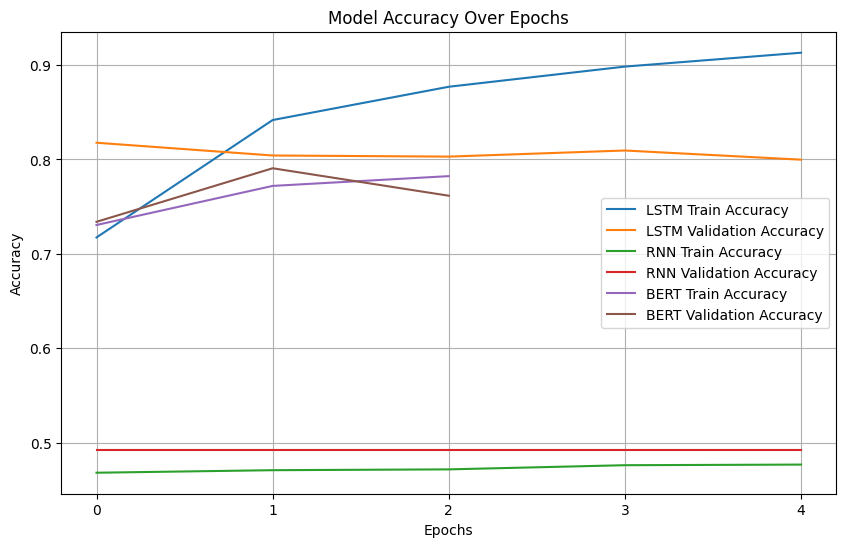

In [34]:
def plot_accuracy_over_epochs(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(histories[0].history['accuracy'])))
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to plot the accuracy over epochs
plot_accuracy_over_epochs([history_lstm, history_rnn, history_bert], ['LSTM', 'RNN', 'BERT'])


In [35]:
# Create a DataFrame for model performance
summary_data = {
    'Model': ['LSTM', 'RNN', 'BERT'],
    'Accuracy': [0.80, 0.49, 0.76],
    'Precision': [0.81, 0.24, 0.78],
    'Recall': [0.80, 0.49, 0.76],
    'F1-Score': [0.80, 0.32, 0.76]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)


  Model  Accuracy  Precision  Recall  F1-Score
0  LSTM      0.80       0.81    0.80      0.80
1   RNN      0.49       0.24    0.49      0.32
2  BERT      0.76       0.78    0.76      0.76
